In [1]:
import random
import numpy as np
import pandas as pd
import copy
import time
from sklearn.preprocessing import StandardScaler

In [2]:
class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
        # helper variables
        self.bias_nitem = sum(sizes[1:])
        self.weight_nitem = sum([self.weights[i].size for i in range(self.num_layers-2)])
        self.counter = 0

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w,a)+b)
        return a

    def sigmoid(self, z):
        return 1.0/(1.0+np.exp(-z))

    def score(self, X, y):
        total_score=0
        for i in range(X.shape[0]):
            predicted = self.feedforward(X[i].reshape(-1,1))
            actual = y[i].reshape(-1,1)
            total_score += np.sum(np.power(predicted-actual,2))  # mean-squared error
        return total_score/X.shape[0]
    
    def score_vector(self, X, y):
        total_score=0
        for i in range(X.shape[0]):
            predicted = self.feedforward(X[i].reshape(-1,1))
            actual = y[i].reshape(-1,1)
            total_score += np.sum(np.power(predicted-actual,2))
        total_score=total_score/X.shape[0] # mean-squared error
        return (1/(1+total_score))

    def accuracy(self, X, y):
        accuracy = 0
        for i in range(X.shape[0]):
            output = (self.feedforward(X[i].reshape(-1,1))).reshape(-1)
            condition = True
            for j in range(len(output)):
                output[j] = round(output[j])
            for j in range(len(output)):
                if(output[j]!=y[i][j]):
                    condition = False
                    break
            if condition:
                accuracy += 1
        return accuracy / X.shape[0] * 100

    def __str__(self):
        s = "\nBias:\n\n" + str(self.biases)
        s += "\nWeights:\n\n" + str(self.weights)
        s += "\n\n"
        return s

In [3]:
class NN_ABC_Algo:

    def __init__(self, n_pops, net_size, X, y, X_test, y_test):
        self.n_pops = n_pops
        self.net_size = net_size
        self.nets = [Network(self.net_size) for i in range(self.n_pops)]
        self.X = X[:]
        self.y = y[:]
        self.X_test = X_test[:]
        self.y_test = y_test[:]
        self.accuracy_train = []
        self.accuracy_test = []
        self.limit = self.n_pops
        self.best = Network(self.net_size)
    
    def get_random_point(self, type):
        nn = self.nets[0]
        layer_index, point_index = random.randint(0, nn.num_layers-2), 0
        if type == 'weight':
            row = random.randint(0,nn.weights[layer_index].shape[0]-1)
            col = random.randint(0,nn.weights[layer_index].shape[1]-1)
            point_index = (row, col)
        elif type == 'bias':
            point_index = random.randint(0,nn.biases[layer_index].size-1)
        return (layer_index, point_index)

    def get_all_scores(self,Xc,yc):
        return [net.score(Xc, yc) for net in self.nets]

    def get_all_scores_vector(self,Xc,yc):
        return [net.score_vector(Xc, yc) for net in self.nets]

    def get_all_accuracy(self,Xc,yc):
        return [net.accuracy(Xc, yc) for net in self.nets]
    
    def initialization_phase(self):
        for i in range(self.n_pops):
            weight = copy.deepcopy(self.nets[i].weights)
            for x in range(len(weight)):
                for y in range(len(weight[x])):
                    for z in range(len(weight[x][y])):
                        weight[x][y][z]=self.nets[i].weights[x][y].min() + np.random.rand()*(self.nets[i].weights[x][y].max()-self.nets[i].weights[x][y].min())
            self.nets[i].weights = copy.deepcopy(weight)
            biases = copy.deepcopy(self.nets[i].biases)
            for x in range(len(biases)):
                for y in range(len(biases[x])):
                    for z in range(len(biases[x][y])):
                        biases[x][y][z]=self.nets[i].biases[x].min() + np.random.rand()*(self.nets[i].biases[x].max()-self.nets[i].biases[x].min())
            self.nets[i].biases = copy.deepcopy(biases)

    def employeed_phase(self,Xc,yc):
        nets = copy.deepcopy(self.nets)
        for i in range(self.n_pops):
            r = list(range(0,i)) + list(range(i+1,self.n_pops))
            coceg = random.choice(r)
            fi1 = random.uniform(-1,1)
            fi2 = random.uniform(-1,1)
            nn = copy.deepcopy(self.nets[i])
            for t in range(1):
                # get some random points
                layer1, point1 = self.get_random_point('bias')
                # replace genetic (bias) with mother's value
                nn.biases[layer1][point1] = nn.biases[layer1][point1] + fi1*(nn.biases[layer1][point1]-self.nets[coceg].biases[layer1][point1])
                layer2, point2 = self.get_random_point('weight')
                # replace genetic (weights) with mother's value
                nn.weights[layer2][point2] = nn.weights[layer2][point2] + fi2*(nn.weights[layer2][point2]-self.nets[coceg].weights[layer2][point2])
            if(nn.score_vector(Xc,yc)>nets[i].score_vector(Xc,yc)):
                nn.counter = 0
                nets[i] = copy.deepcopy(nn)
            else:
                nets[i].counter += 1
        self.nets = copy.deepcopy(nets)
        
    def onlooked_phase(self,Xc,yc):
        all_scores_vector = self.get_all_scores_vector(Xc,yc)
        sum = np.sum(all_scores_vector)
        probability = all_scores_vector/sum
        nets = copy.deepcopy(self.nets)
        for i in range(self.n_pops):
            index_solution = np.random.choice(list(range(self.n_pops)),p=probability)
            r = list(range(0,index_solution)) + list(range(index_solution+1,self.n_pops))
            coceg = random.choice(r)
            fi1 = random.uniform(-1,1)
            fi2 = random.uniform(-1,1)
            nn = copy.deepcopy(self.nets[index_solution])
            for t in range(1):
                # get some random points
                layer1, point1 = self.get_random_point('bias')
                # replace genetic (bias) with mother's value
                nn.biases[layer1][point1] = nn.biases[layer1][point1] + fi1*(nn.biases[layer1][point1]-self.nets[coceg].biases[layer1][point1])
                layer2, point2 = self.get_random_point('weight')
                # replace genetic (weights) with mother's value
                nn.weights[layer2][point2] = nn.weights[layer2][point2] + fi2*(nn.weights[layer2][point2]-self.nets[coceg].weights[layer2][point2])
            if(nn.score_vector(Xc,yc)>nets[index_solution].score_vector(Xc,yc)):
                nn.counter = 0
                nets[index_solution] = copy.deepcopy(nn)
            else:
                nets[index_solution].counter += 1
        self.nets = copy.deepcopy(nets)

    def scout_phase(self):
        for i in range(self.n_pops):
            if self.nets[i].counter > self.limit:
                weight = copy.deepcopy(self.nets[i].weights)
                for x in range(len(weight)):
                    for y in range(len(weight[x])):
                        for z in range(len(weight[x][y])):
                            weight[x][y][z]=self.nets[i].weights[x][y].min() + np.random.rand()*(self.nets[i].weights[x][y].max()-self.nets[i].weights[x][y].min())
                self.nets[i].weights = copy.deepcopy(weight)
                biases = copy.deepcopy(self.nets[i].biases)
                for x in range(len(biases)):
                    for y in range(len(biases[x])):
                        for z in range(len(biases[x][y])):
                            biases[x][y][z]=self.nets[i].biases[x].min() + np.random.rand()*(self.nets[i].biases[x].max()-self.nets[i].biases[x].min())
                self.nets[i].biases = copy.deepcopy(biases)
                self.nets[i].counter = 0
                
    def sort_nets(self,Xc,yc):
        # calculate score for each population of neural-net
        score_list = list(zip(self.nets, self.get_all_scores(Xc,yc)))

        # sort the network using its score
        score_list.sort(key=lambda x: x[1])

        # exclude score as it is not needed anymore
        score_list = [obj[0] for obj in score_list]
        self.nets = copy.deepcopy(score_list)
        if(self.best.accuracy(self.X,self.y)<self.nets[0].accuracy(self.X,self.y)):
            self.best = copy.deepcopy(self.nets[0])

    def evolve(self):
        start_time = time.time()
        self.initialization_phase()
        for t in range(25):
            self.accuracy_train.append(self.best.accuracy(self.X,self.y))
            self.accuracy_test.append(self.best.accuracy(self.X_test,self.y_test))
            for i in range(40):
                j1=i*40
                j2=(1+i)*40
                Xc=self.X[j1:j2,:]
                yc=self.y[j1:j2,:]
                for k in range(25):  
                    self.employeed_phase(Xc,yc)
                    self.onlooked_phase(Xc,yc)
                    self.scout_phase()
                    self.sort_nets(Xc,yc)
                print("Current iteration : {}, batch : {}".format(t+1,i+1))
                print("Time taken by far : %.1f seconds" % (time.time() - start_time))
                print("Current top member's network score: %.5f " % self.best.score(self.X,self.y))
                print("Current top member's network accuracy: %.2f%%\n" % self.best.accuracy(self.X,self.y))

In [4]:
df = pd.read_csv("../Data/data_(12-12).csv")

In [5]:
X = df.iloc[:1600, :12].values
y = df.iloc[:1600, 12:24].values
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = df.iloc[1600:2000, :12].values
y_test = df.iloc[1600:2000, 12:24].values
sc = StandardScaler()
X_test = sc.fit_transform(X_test)

In [6]:
N_POPS = 100
NET_SIZE = [12,12,12]
nnabc = NN_ABC_Algo(N_POPS, NET_SIZE, X, y, X_test, y_test)
nnabc.evolve()

Current iteration : 1, batch : 1
Time taken by far : 43.9 seconds
Current top member's network score: 2.10316 
Current top member's network accuracy: 0.19%

Current iteration : 1, batch : 2
Time taken by far : 86.3 seconds
Current top member's network score: 1.86014 
Current top member's network accuracy: 5.56%

Current iteration : 1, batch : 3
Time taken by far : 127.0 seconds
Current top member's network score: 1.70815 
Current top member's network accuracy: 21.12%

Current iteration : 1, batch : 4
Time taken by far : 166.3 seconds
Current top member's network score: 1.66584 
Current top member's network accuracy: 47.06%

Current iteration : 1, batch : 5
Time taken by far : 203.9 seconds
Current top member's network score: 1.66584 
Current top member's network accuracy: 47.06%

Current iteration : 1, batch : 6
Time taken by far : 245.5 seconds
Current top member's network score: 1.66584 
Current top member's network accuracy: 47.06%

Current iteration : 1, batch : 7
Time taken by far

C:\Users\nguye\AppData\Local\Temp/ipykernel_7972/4068189173.py:20: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


Current iteration : 1, batch : 12
Time taken by far : 491.2 seconds
Current top member's network score: 1.57442 
Current top member's network accuracy: 47.94%

Current iteration : 1, batch : 13
Time taken by far : 531.5 seconds
Current top member's network score: 1.57442 
Current top member's network accuracy: 47.94%

Current iteration : 1, batch : 14
Time taken by far : 572.0 seconds
Current top member's network score: 1.57442 
Current top member's network accuracy: 47.94%

Current iteration : 1, batch : 15
Time taken by far : 610.6 seconds
Current top member's network score: 1.57442 
Current top member's network accuracy: 47.94%

Current iteration : 1, batch : 16
Time taken by far : 650.2 seconds
Current top member's network score: 1.57442 
Current top member's network accuracy: 47.94%

Current iteration : 1, batch : 17
Time taken by far : 691.4 seconds
Current top member's network score: 1.57442 
Current top member's network accuracy: 47.94%

Current iteration : 1, batch : 18
Time t

Current top member's network accuracy: 49.69%

Current iteration : 2, batch : 24
Time taken by far : 2724.1 seconds
Current top member's network score: 1.46873 
Current top member's network accuracy: 49.69%

Current iteration : 2, batch : 25
Time taken by far : 2765.1 seconds
Current top member's network score: 1.46873 
Current top member's network accuracy: 49.69%

Current iteration : 2, batch : 26
Time taken by far : 2806.2 seconds
Current top member's network score: 1.46873 
Current top member's network accuracy: 49.69%

Current iteration : 2, batch : 27
Time taken by far : 2846.9 seconds
Current top member's network score: 1.46873 
Current top member's network accuracy: 49.69%

Current iteration : 2, batch : 28
Time taken by far : 2888.5 seconds
Current top member's network score: 1.41293 
Current top member's network accuracy: 55.25%

Current iteration : 2, batch : 29
Time taken by far : 2929.8 seconds
Current top member's network score: 1.41293 
Current top member's network accur

Current top member's network accuracy: 57.06%

Current iteration : 3, batch : 35
Time taken by far : 4889.2 seconds
Current top member's network score: 1.38971 
Current top member's network accuracy: 57.06%

Current iteration : 3, batch : 36
Time taken by far : 4932.2 seconds
Current top member's network score: 1.39811 
Current top member's network accuracy: 57.38%

Current iteration : 3, batch : 37
Time taken by far : 4974.4 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 3, batch : 38
Time taken by far : 5017.7 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 3, batch : 39
Time taken by far : 5060.4 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 3, batch : 40
Time taken by far : 5102.3 seconds
Current top member's network score: 1.36282 
Current top member's network accur

Current top member's network accuracy: 57.44%

Current iteration : 5, batch : 6
Time taken by far : 7067.6 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 5, batch : 7
Time taken by far : 7110.2 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 5, batch : 8
Time taken by far : 7152.9 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 5, batch : 9
Time taken by far : 7196.2 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 5, batch : 10
Time taken by far : 7239.6 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 5, batch : 11
Time taken by far : 7282.7 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy:

Current top member's network accuracy: 57.44%

Current iteration : 6, batch : 17
Time taken by far : 9071.8 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 6, batch : 18
Time taken by far : 9108.2 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 6, batch : 19
Time taken by far : 9145.1 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 6, batch : 20
Time taken by far : 9181.2 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 6, batch : 21
Time taken by far : 9217.5 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 6, batch : 22
Time taken by far : 9253.1 seconds
Current top member's network score: 1.36282 
Current top member's network accur

Current iteration : 7, batch : 28
Time taken by far : 10945.5 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 7, batch : 29
Time taken by far : 10982.8 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 7, batch : 30
Time taken by far : 11016.3 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 7, batch : 31
Time taken by far : 11048.4 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 7, batch : 32
Time taken by far : 11091.4 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 7, batch : 33
Time taken by far : 11124.3 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 7, batch

Current iteration : 8, batch : 39
Time taken by far : 12535.2 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 8, batch : 40
Time taken by far : 12567.8 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 9, batch : 1
Time taken by far : 12600.5 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 9, batch : 2
Time taken by far : 12630.3 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 9, batch : 3
Time taken by far : 12661.4 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 9, batch : 4
Time taken by far : 12692.3 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 9, batch : 5

Current top member's network accuracy: 57.44%

Current iteration : 10, batch : 10
Time taken by far : 14262.4 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 10, batch : 11
Time taken by far : 14297.5 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 10, batch : 12
Time taken by far : 14332.4 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 10, batch : 13
Time taken by far : 14367.6 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 10, batch : 14
Time taken by far : 14404.6 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 10, batch : 15
Time taken by far : 14442.2 seconds
Current top member's network score: 1.36282 
Current top member's n

Current iteration : 11, batch : 21
Time taken by far : 16110.6 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 11, batch : 22
Time taken by far : 16150.6 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 11, batch : 23
Time taken by far : 16189.6 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 11, batch : 24
Time taken by far : 16228.6 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 11, batch : 25
Time taken by far : 16267.4 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 11, batch : 26
Time taken by far : 16307.2 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 11

Current iteration : 12, batch : 32
Time taken by far : 18018.1 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 12, batch : 33
Time taken by far : 18050.9 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 12, batch : 34
Time taken by far : 18083.3 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 12, batch : 35
Time taken by far : 18116.0 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 12, batch : 36
Time taken by far : 18148.4 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 12, batch : 37
Time taken by far : 18181.7 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 12

Current iteration : 14, batch : 3
Time taken by far : 19667.3 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 14, batch : 4
Time taken by far : 19699.0 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 14, batch : 5
Time taken by far : 19730.3 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 14, batch : 6
Time taken by far : 19762.6 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 14, batch : 7
Time taken by far : 19793.9 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 14, batch : 8
Time taken by far : 19825.5 seconds
Current top member's network score: 1.36282 
Current top member's network accuracy: 57.44%

Current iteration : 14, batc

KeyboardInterrupt: 

In [12]:
nnabc.best.accuracy(X,y)

C:\Users\nguye\AppData\Local\Temp/ipykernel_7972/4068189173.py:20: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


57.4375

In [13]:
nnabc.best.accuracy(X_test,y_test)

C:\Users\nguye\AppData\Local\Temp/ipykernel_7972/4068189173.py:20: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


57.75

In [7]:
accuracy_train = np.array(nnabc.accuracy_train)
accuracy_test = np.array(nnabc.accuracy_test)

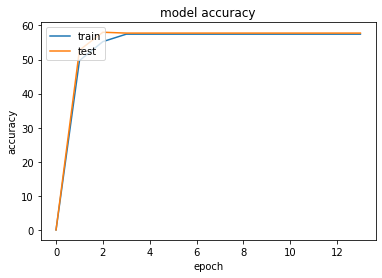

In [8]:
from matplotlib import pyplot as plt
plt.plot(accuracy_train)
plt.plot(accuracy_test )
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
# Neural network
model = Sequential()
model.add(Dense(12, input_dim=12, activation="sigmoid"))
model.add(Dense(12, activation="sigmoid"))

In [10]:
for i in range(len(model.layers)):
    model.layers[i].set_weights([nnabc.best.weights[i].T,nnabc.best.biases[i].reshape(-1)])

In [11]:
from keras.models import load_model
model.save('model_NN_ABC_12_12_12.h5')  # creates a HDF5 file 'my_model.h5'
del model